# Final Model Analysis

### For this notebook I will dive deep into the model and extract useful information that will hopefully provide actionable insights

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import category_encoders as ce
import time

In [2]:
def evaluate(estimator, X_train, X_test, y_train, y_test):
    '''
    Evalutaion function to show scoring metrics such as f1, ROC AUC, accuracy, precision and recall
    for both the train and test sets
    Also will show a confusion matrix
    '''
    # set predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {np.round(accuracy_score(y_train, train_preds)*100, 2)}%")
    print(f"F1: {np.round(f1_score(y_train, train_preds)*100, 2)}%")
    print(f"ROC-AUC: {np.round(roc_auc_score(y_train, train_preds)*100, 2)}%")
    print(f"Precision: {np.round(precision_score(y_train, train_preds)*100, 2)}%")
    print(f"Recall: {np.round(recall_score(y_train, train_preds)*100, 2)}%")
    print("------" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {np.round(accuracy_score(y_test, test_preds)*100, 2)}%")
    print(f"F1: {np.round(f1_score(y_test, test_preds)*100, 2)}%")
    print(f"ROC-AUC: {np.round(roc_auc_score(y_test, test_preds)*100, 2)}%")
    print(f"Precision: {np.round(precision_score(y_test, test_preds)*100, 2)}%")
    print(f"Recall: {np.round(recall_score(y_test, test_preds)*100, 2)}%")
    
    # plot test confusion matrix   
    plot_confusion_matrix(estimator, X_test, y_test)


In [3]:
DF = pd.read_csv('Cleaned_DF')

X = DF.drop(['status_group'], axis=1)
y = DF['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

# To deal with categorical values, I will group columns together based on the frequency of values
# create column with numeric values 
# create column with values less than 10 categories to OHE
# create column with values more than 10 categories

num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if DF[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif len(DF[c].unique()) <= 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)
        
        
print(f"Numeric: {num_cols}")
print(f"OHE: {ohe_cols}")
print(f"Frequency: {freq_cols}")

Numeric: ['amount_tsh', 'gps_height', 'public_meeting', 'permit', 'construction_year']
OHE: ['basin', 'extraction_type_class', 'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type']
Frequency: ['funder', 'installer', 'wpt_name', 'subvillage', 'region', 'scheme_management', 'management']


In [4]:
# Dealing with numeric values and adding a min-max scaler and replacing null values with the median value
numeric_transformer = Pipeline(steps=[("num_imputer", SimpleImputer(strategy="median")), 
                                      ("scaler", MinMaxScaler())])
# Dealing with categorical columns with less than 10 unique values by One Hot Encoding them. No null values
ohe_transformer = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown='ignore'))])

# Dealing with Categorical columns with more than 10 unique values by using Count Encoder 
freq_transformer = Pipeline(steps=[("freq_enc", ce.CountEncoder(normalize=True, 
                                                                min_group_size=0.01,
                                                                min_group_name='other'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat_ohe", ohe_transformer, ohe_cols),
        ("cat_freq", freq_transformer, freq_cols)], remainder='passthrough')

In [5]:
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', KNeighborsClassifier(n_neighbors=11, weights='uniform'))])

clf_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'public_meeting', 'permit',
                                                   'construction_year']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                          

Train Scores
------------
Accuracy: 84.45%
F1: 87.26%
ROC-AUC: 83.09%
Precision: 83.57%
Recall: 91.29%
------------------------------
Test Scores
-----------
Accuracy: 82.4%
F1: 85.72%
ROC-AUC: 80.87%
Precision: 82.61%
Recall: 89.07%


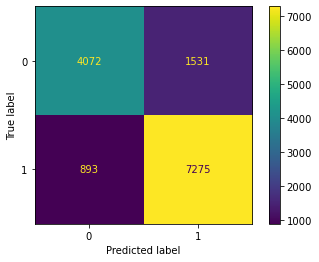

In [6]:
evaluate(clf_knn, X_train, X_test, y_train, y_test)

In [7]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

get_column_names_from_ColumnTransformer(preprocessor)

['amount_tsh',
 'gps_height',
 'public_meeting',
 'permit',
 'construction_year',
 'x0_Internal',
 'x0_Lake Nyasa',
 'x0_Lake Rukwa',
 'x0_Lake Tanganyika',
 'x0_Lake Victoria',
 'x0_Pangani',
 'x0_Rufiji',
 'x0_Ruvuma / Southern Coast',
 'x0_Wami / Ruvu',
 'x1_gravity',
 'x1_handpump',
 'x1_motorpump',
 'x1_other',
 'x1_rope pump',
 'x1_submersible',
 'x1_wind-powered',
 'x2_never pay',
 'x2_other',
 'x2_pay annually',
 'x2_pay monthly',
 'x2_pay per bucket',
 'x2_pay when scheme fails',
 'x2_unknown',
 'x3_coloured',
 'x3_fluoride',
 'x3_fluoride abandoned',
 'x3_milky',
 'x3_salty',
 'x3_salty abandoned',
 'x3_soft',
 'x3_unknown',
 'x4_dry',
 'x4_enough',
 'x4_insufficient',
 'x4_seasonal',
 'x4_unknown',
 'x5_borehole',
 'x5_dam',
 'x5_other',
 'x5_rainwater harvesting',
 'x5_river/lake',
 'x5_shallow well',
 'x5_spring',
 'x6_cattle trough',
 'x6_communal standpipe',
 'x6_communal standpipe multiple',
 'x6_dam',
 'x6_hand pump',
 'x6_improved spring',
 'x6_other',
 'funder',
 'in

In [8]:
def plot_20(model):
    
    feature_names = get_column_names_from_ColumnTransformer(preprocessor)
    coef = model.named_steps['classifier'].classes_

    # Zip coefficients and names together and make a DataFrame
    zipped = zip(feature_names, coef)
    df = pd.DataFrame(sorted(zipped), columns=["feature", "value"])
    # Sort the features by the absolute value of their coefficient
    df["abs_value"] = df["value"].apply(lambda x: abs(x))
    df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
    df = df.sort_values("abs_value", ascending=False)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(x="feature",
                y="value",
                data=df.head(20),
               palette=df.head(20)["colors"],
               orient='v')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 20 Features", fontsize=25)
    ax.set_ylabel("Coef", fontsize=22)
    ax.set_xlabel("Feature Name", fontsize=22)
    plt.show()